**Word Count:** 2996

_The Quarto environment was used to render this report, with all code written in Python [@Allaire_Quarto_2022]. The pandas [@pandas], numpy [@numpy], sci-kit learn [@sklearn], scipy [@scipy] and joblib [@joblib] Python packages are also required to generate this report:_

In [1]:
try:
  import pandas as pd
except:
  !pip install pandas
  import pandas as pd

try:
  import numpy as np
except:
  !pip install numpy
  import numpy as np

try:
  import sklearn
except:
  !pip install scikit-learn
  import sklearn

try:
  import joblib
except:
  !pip install joblib
  import joblib

try:
  import scipy
except:
  !pip install scipy
  import scipy

try:
  import matplotlib.pyplot
except:
  !pip install matplotlib
  import matplotlib.pyplot

import warnings #preinstalled I think
warnings.simplefilter(action='ignore', category=FutureWarning)

import os #preinstalled I think
import statistics #preinstalled I think

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from joblib import load

_The following functions are used in the creation of figures 2 to 4._

In [2]:
def read_all_csvs_to_df(directory_path):
    csv_files = os.listdir(directory_path) # Get list of csv file names
    data_rows = []
    for csv_file in csv_files:
        df = pd.read_csv(directory_path + "/" + csv_file)
        df_complex = df.applymap(complex) 
        df_real = df_complex.applymap(np.real) # Keeping only the real part of the model
        flattened_data = df_real.values.flatten()
        data_rows.append(flattened_data)
    final_df = pd.DataFrame(data_rows)
    final_df.columns = [f'col_{i}' for i in range(final_df.shape[1])] # Renaming the columns
    return final_df

def read_live_csvs_to_df(directory_path): # Data has already been cleaned (real value taken) during live recording process
    csv_files = os.listdir(directory_path) # Get list of csv file names
    exists = False # Boolean to set up the dataframe
    for csv_file in csv_files:
        if exists == False:
            final_df = pd.read_csv(directory_path + "/" + csv_file)
            exists = True
        else:
            new_df = pd.read_csv(directory_path + "/" + csv_file)
            final_df = pd.concat([final_df.copy(), new_df], ignore_index=True) #Just concatenating them
    return final_df

def stdev(scaled_list): # Calculating the SD to compare against threshold
    return statistics.stdev(scaled_list[:4800])

def predict_sd(scaled_list): # Predicting an event based on the threshold
    if scaled_list[-2] >= threshold:
        prediction = 1
    else:
        prediction = 0
    return prediction

def evaluate_cm(cm, labels): # Computing individual performance statistics from a confusion matrix
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    results_breakdown = pd.DataFrame(columns=labels)
    results_breakdown.loc["False Positive Rate"] = np.around(FP/(FP+TN),decimals=3)
    results_breakdown.loc["False Negative Rate"] = np.around(FN/(TP+FN),decimals=3)
    results_breakdown.loc["Sensitivity"] = np.around(TP/(TP+FN),decimals=3)
    results_breakdown.loc["Specificity"] = np.around(TN/(TN+FP) ,decimals=3)
    results_breakdown.loc["Precision"] = np.around(TP/(TP+FP),decimals=3)
    results_breakdown.loc["Negative Predictive Value"] = np.around(TN/(TN+FN),decimals=3)
    results_breakdown.loc["Accuracy"] = np.around((TP+TN)/(TP+FP+FN+TN),decimals=3)

    return results_breakdown

# Executive Summary

## Problem Statement
Over 80% of young Australians (aged 18-44) stream music at an average of 13.3 hours per week [@acma_2020]. A substantial proportion of these hours are spent using a variety of earphone or headphone style devices whilst engaged in other tasks such as work and exercising. The music controls often built into these devices require use of your hands which can be inconvenient, distracting, or even dangerous. 

## Main Findings
The successful development of our prototype audio control system ‘iControl’ involved careful consideration of data collection, processing, model training, and deployment. A Neuron SpikerBox was used to manually collect the characteristic voltage signals produced from various eye movements. An optimised random forest model grid-search was then used to classify and map these signals to specific music controls of play, pause, skip, rewind, and activation with a double blink. The training accuracy achieved for this model was 99.0% and 96.7% when tested on 60 unseen data samples. Our prototype achieved an impressive average latency of 945±53 ms. However, calibration is currently required for the model to work accurately on unseen individuals.  

## Practical Relevance
iControl provides an easy and convenient way to control music without requiring the use of your hands. A faster and more accurate prototype, along with a hardware implementation in a product such as glasses, will result in a more viable product to be taken on by customers. 

# Aim and Background

## Aim
The aim of our project was to develop a program to control music through eye movement, providing an alternative to current clunky, inconvenient, and inaccurate haptics for audio devices. This project employs effective applications of physical and data science concepts to create an accurate and fast working model to map eye movements to audio controls with our product, iControl. 

## Background
The eye contains an electrical dipole with the negative pole at the back of the eye at the fundus, and a positive pole at the cornea [@Täumer1974]. Electro-oculography (EOG) devices are commonly used for the detection of biosignals such as brain activity and eye movements. The control of various computer functions through eye movements is therefore a good candidate for this type of technology. EOG signals are often susceptible to noise which necessitates the careful adjustment of the physical setup and data processing to aid the extraction of useful information through filtering. To develop these adjustments, knowledge from different fields is required to create a robust final product. 

To create a prototype, existing hardware in the form of a Neuron SpikerBox was used. To measure EOG signals, electrodes were attached around the eye. This device allows for a specified quantity of data to be sent to an external device with sizes of 2000-20000 data points. This data can then be filtered to increase the signal to noise ratio, a job requiring sound understanding of the physical application of Fourier transforms and Gaussian filtering. The format of this data can be previewed in Table A3. This data can then be processed further by the external device, requiring the role of data science to create optimised classification models, utilising supervised learning algorithms to predict labels for eye movements. A large amount of data is needed for adequate classifier training, lending to the importance of well-considered experimental methodologies. The unification of these disciplinary considerations was therefore essential for reaching our goal and producing an effective product.

# Methods

## Figure 1: Overview Flowchart

A graphical overview of the training and live streaming workflows of iControl are displayed in Figure 1. These are covered in more depth throughout the methods and results sections.

![Figure 1: A summary of the training and live streaming workflows of iControl.](figures/fig_1.png)

## Training Data Collection
The EOG electrodes were placed semi diagonally above the right eye, with our data collected as 1000ms windows consisting of two 500ms buffers. Data processing was performed while collecting the data, which involved a Gaussian low-pass filter (frequency domain) and a ‘window function’ (time domain). The Gaussian filter in our final approach took a Fourier transform of the 1000ms event window, multiplied the result (in the frequency domain) by a Gaussian function with a width (standard deviation) of 25/√2 (centre of 0), and then inverse Fourier transformed back into the time domain, discarding the imaginary component of the values. 

During the early data collection process, flaws in the appending and pre-processing of buffers created spikes at 500ms intervals. After solving the immediate appending issue, which was found in both the unprocessed and processed data, the ‘spiking’ still partially remained in our processed data. It was found that, rather than applying to the entire window, our data pre-processing (Gaussian low-pass filter) was applied to the individual buffers with our ‘window function’ also incorrectly implemented, resulting in significant edge-effects where the buffers joined. To remove these spikes, the first and last 20ms of each window was removed. New training data was then collected with the correct appending and data-preprocessing.

After constructing a working general event classifier, data was also collected using the live streaming code. This was done by performing several of each event, and saving any events that passed through the general event classifier. This greatly improved live model performance, as previous event recordings had events too ‘centred’ in the window due to the anticipation of the students collecting the data.

To improve fairness, data was collected by two physics students, using several SpikerBoxes. In total 203 blinks, 202 left, 213 right, 201 non-events were collected using the manual collection method. The data collected using the live streaming code included 87 blinks, 81 lefts and 88 rights. These were combined to help train the final model.

## Model Development
Since the model needed to be applied in real-time, it was integral that we minimised unnecessary computation. To approach this, a simple model was selected to first classify a window as either an event or non-event. A zero-crossing model was initially tested, with min-max normalisation performed to determine the zero point of the data. This resulted in poor live performance as the zero value of windows that contained segments of multiple events, or only part of an event, would not be a representative baseline value.

A median and mode-crossing classifier were also tested but a classifier based on the standard deviation of our windows ultimately outperformed these other attempts. This classifier works by calculating the standard deviation of the first half of the data window, and comparing it to a predetermined threshold. If the standard deviation was above the threshold, it would be classified as an event, and passed onto the random forest classifier for specific classification.

To determine the optimal standard deviation threshold, thresholds from 0 to 80 were tested on the training data, which was divided in a random 10-fold split. A total of 874 events and 201 non-events were evaluated, with the distribution of the accuracy for each threshold recorded and plotted below in Figure 2. Although a threshold of around 10 to 20 seemed to attain the maximum accuracy, it was ultimately decided to select a higher threshold of 35 to minimise false positives.

Accuracy for 35: 93.58% ± 0.63


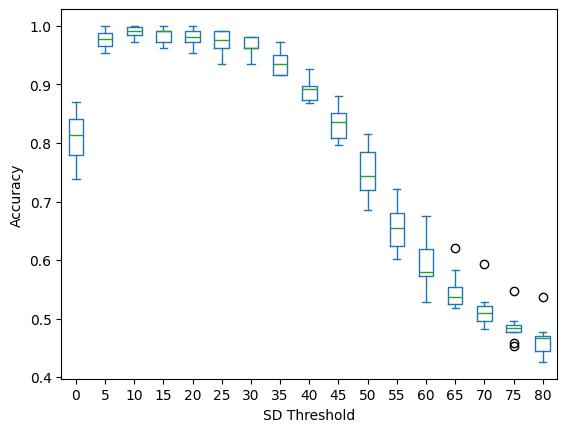

In [3]:
#| label: fig2
#| fig-cap: "Figure 2: Box plot illustrating the distribution of accuracy, when applying the standard-deviation based general event classifier to 10 folds of randomly-divided training data at varying thresholds."

# Importing the original data that was used to train the model
blinks = read_all_csvs_to_df("train_data/blinks")
left = read_all_csvs_to_df("train_data/left")
right = read_all_csvs_to_df("train_data/right")
nonevents = read_all_csvs_to_df("train_data/non_events")

# Importing the live data that was used to train the model
blinks_live = read_live_csvs_to_df("train_data/blinks_live")
left_live = read_live_csvs_to_df("train_data/left_live")
right_live = read_live_csvs_to_df("train_data/right_live")

# Joining them together now that they're in the same format
blinks = pd.concat([blinks, blinks_live], ignore_index=True)
left = pd.concat([left, left_live], ignore_index=True)
right = pd.concat([right, right_live], ignore_index=True)

# Creating data frames for events/nonevents for general event classifier and adding label column
fig2_events = pd.concat([blinks, left, right], ignore_index=True)
fig2_events = fig2_events.dropna(axis='columns')
fig2_events['sd'] = fig2_events.apply(stdev, axis = 1)
fig2_events['label'] = 1
fig2_nonevents = nonevents.copy()
fig2_nonevents = fig2_nonevents.dropna(axis='columns')
fig2_nonevents['sd'] = fig2_nonevents.apply(stdev, axis = 1)
fig2_nonevents['label'] = 0

fig2_combined = pd.concat([fig2_events, fig2_nonevents], axis = 0)

# Shuffle with random state set for reproducibility, and split into 10 folds
fig2_split = np.array_split(shuffle(fig2_combined, random_state = 3888), 10)

results = list()
for i in range(len(fig2_split)):
    threshold = 0

    results.append(pd.DataFrame({'threshold': [], 'acc_' + str(i): []}))

    while threshold <= 80: # Testing every threshold from 0 to 80 in increments of 5
        predicted = fig2_split[i].copy()
        predicted['prediction'] = predicted.apply(predict_sd, axis = 1)
        confusion = predicted.groupby(['label','prediction']).size().reset_index()
        correct = 0
        j = 0
        while j < len(confusion[0]):
            if confusion['label'][j] == confusion['prediction'][j]:
                correct = correct + confusion[0][j]
            j += 1
        accuracy = correct/sum(confusion[0])
        results[i].loc[len(results[i])] = [str(int(threshold)), accuracy] 
        threshold += 5

results_plot = results[0].set_index("threshold")

for i in range(1, len(results)):
    results_plot = results_plot.join(results[i].set_index("threshold"))

# Calculating mean and standard error for final threshold selected of 35 
gen_error = str(round(statistics.mean(results_plot.iloc[7])*100, 2)) + "% ± " + str(round(scipy.stats.sem(results_plot.iloc[7])*100, 2))
print("Accuracy for 35: " + gen_error)

fig_2 = results_plot.transpose().plot(kind = 'box', xlabel = "SD Threshold", ylabel = "Accuracy")
fig_2.figure.savefig("figures/fig_2.png") # Saving figure as png just in case

A more complex classifier was selected for classifying the events as either blink, left or right. Initially, k-Nearest Neighbour (kNN), random forest, and support vector machine (SVM) were explored and compared using 10-fold cross validation but it was ultimately decided to train a random forest model. Given the large number of features in each window (9600), feature selection using tsfresh was initially incorporated to help improve accuracy and latency. Although this presented promising accuracy, the latency was unacceptable. Training a random forest model using the sci-kit learn library on all 9600 features directly, without any preprocessing proved significantly more efficient. This model was trained on the data from blinks, left and right movements, and non-events. This allowed the model to filter out any false positives that may have made it past the simple general event classifier.

A grid search using GridSearchCV was performed to tune the model’s hyperparameters, with the following search space:

In [4]:
#| code-fold: false
#| code-line-numbers: false

grid_space={'max_depth':[5,10,None],
              'n_estimators':[50,100,200],
              'max_features':['sqrt',5,7],
              'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10]
           }

The best hyperparameters were: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}. This achieved the following prediction accuracy, with the confusion matrix for this shown in Figure 3.

Accuracy: 98.98%


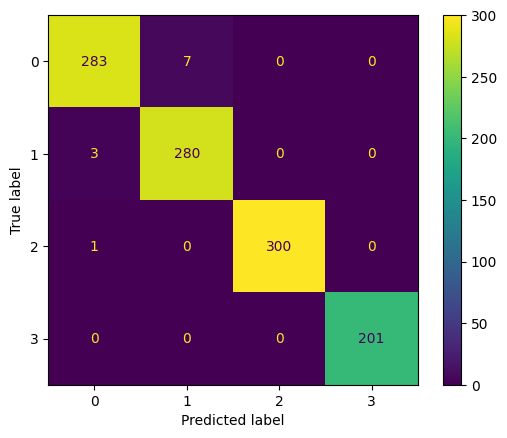

In [5]:
#| label: fig3
#| fig-cap: "Figure 3: Confusion matrix describing the training performance of the final random forest model, after hyperparameter optimisation. 0 represents blink (n = 290), 1 represents left (n = 283), 2 represents right (n = 301), and 3 represents a non-event (n = 201). Event specific performance metrics are described in Table A1."

# Same data imported for Figure 2 is used here
blinks['label'] = 0
left['label'] = 1
right['label'] = 2
nonevents['label'] = 4 # Because 3 was reserved for doubleblinks, which were later implemented using a different method

traintest_combined = pd.concat([blinks, left, right, nonevents], axis = 0)

model = load('models/live_rf_b_l_r_ne_combined.joblib') # Loading the final model
X = traintest_combined.drop('label', axis=1)
y = traintest_combined['label']

y_pred = model.predict(X)
# y_pred = cross_val_predict(model, X, y, cv=10)
train_accuracy = accuracy_score(y, y_pred)

print("Accuracy:", str(round(train_accuracy*100, 2)) + "%")
train_cm = confusion_matrix(y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=train_cm).plot().figure_.savefig('figures/fig_3.png') # Saving figure as png just in case

## Evaluation Metrics
To inform the choice of electrode placement, the standard deviation was measured to establish event prominence. The window and buffer size choices were informed by looking at the duration of an event, to ensure the full event was captured. The signal-to-noise ratio was also recorded to inform the choice of filter, with rolling standard deviation used to determine the cut-off of the ‘window function’.

Given that iControl operates in real-time, the key evaluation metrics revolve around latency and accuracy. Overall prediction accuracy was the main evaluation metric during model development, however additional measures such as false positive rate, false negative rate, sensitivity, specificity, precision, negative predictive value and event-specific accuracy were considered. These were calculated for the events individually, to assess if the model had any bias towards certain events. 

To evaluate latency, 15 trials were filmed and slowed down to be analysed frame by frame. The time between completion of the eye movement and iControl’s action was recorded, and averaged over the trials. 


# Results

## Justification of Final Data Collection Approach
Electrode placement was between the eyebrows and one on the temple next to the right eye as it yielded the highest average standard deviation of 119±8, before filtering, for 125 initial events, ensuring events were distinct from noise (Figure A1).

Buffer and window sizes were informed by the size of events during initial data collection, which were approximately 800ms with significant (±200ms) variance. As each request for data forces the SpikerBox to briefly pause collection, the number of buffers per event was minimised to avoid data loss. However, larger buffer sizes necessitated higher latency, therefore a tradeoff buffer size of 500ms was selected. Because 500ms was shorter than the full duration of many events, a rolling window of the two latest buffers was chosen for live operation, which provided enough time to capture most events (1000ms). The rolling ensured the correct classification of events on the boundaries between buffers (Figure A2). 

Our Gaussian filter dramatically increased the signal-to-noise ratio, from 46±4dB to 66±8dB after filtering out frequencies between 49.85 and 50.15Hz for 420 events. As a result, our model was more effective at identifying relevant features as there was less overfitting to noise from mains power in the signals. 

We quantified the extent of edge-effects from filtering by calculating the standard deviation for a rolling 10-frame (1ms) window, and finding the point where the rolling standard deviation was less than 0.1 (indicating the initial edge-effect had subsided). This was found to be at frame 203±9 (i.e. 20.3±0.9ms) for the same 420 events, which was rounded to frame 200 (i.e. 20ms) and chosen as our cut-off.

The imaginary component of the filtered data was discarded, reducing size and allowing us to use the standard deviation of the real component deviation for general event classification.

## Justification of Final Models
Implementing a two-step model with a simple, general classifier before specific event classification helped reduce computational complexity and improved interpretability. General-event detection using a standard deviation threshold of 35 was selected, which achieved a mean accuracy of 93.6±0.6%. Although lower thresholds had higher training accuracies, we prioritised minimising the false positive rate over a slightly higher training accuracy, to avoid unwanted inputs. Our final model had a false positive rate of 0.025 for blinks and left movements, and 0 for right movements (Table A2). 

A random forest model was selected for specific event classification as it yielded the highest accuracy of the tested models, at 98.98%. Random forest models also mitigate overfitting through bootstrap sampling over multiple decision trees, while also minimising prediction latency and handling high-dimensional data efficiently. This made it our most accurate, robust and generalisable model. Considering the optimal hyperparameters, the maximum depth of each tree in the forest was set to 10 and the number of features to consider when splitting at each node to 5. This ensures that the tree is not too deep nor reliant on a large number of features, which helps reduce overfitting. Setting each leaf to have at least one sample, and requiring a minimum of 2 samples to split an internal node allows the tree to grow out fully until the other stopping criteria are met. Having 100 trees creates a balance between having enough trees to make accurate predictions and minimising computational cost. 

Extracting time series features from the data using tsfresh was abandoned due to its unacceptable overall latency ​​of 4.9±0.4s, despite a favourable accuracy of 99.71%.  Resolving this through extracting less features, such as the top 10 instead of all 783, or by smoothing the data offered little to no improvement. Instead, using all 9600 features (each representing a single EOG record) presented sub-second latency while maintaining acceptable accuracy. 

## Model Live Performance
The final model had an average latency of 945±53ms, with an overall live accuracy of:

Accuracy: 96.67%


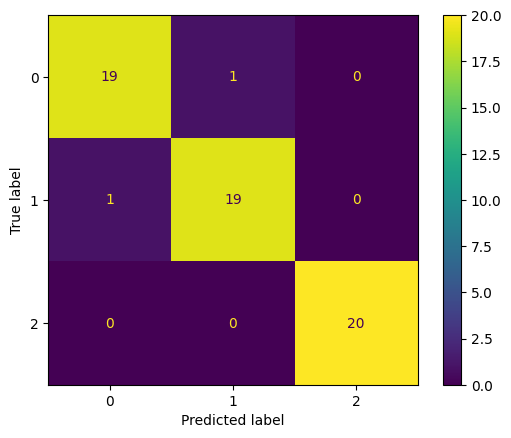

In [6]:
#| label: fig4
#| fig-cap: "Figure 4: Confusion matrix describing the live streamed performance of the final random forest model. 0 represents blink, 1 represents left, and 2 represents right (n = 20). Event specific performance metrics are described in Table A2."

# Importing the live data that wasn't included in the training data
livetest_blinks = read_live_csvs_to_df("live_data/blinks")
livetest_left = read_live_csvs_to_df("live_data/left")
livetest_right = read_live_csvs_to_df("live_data/right")

# Adding labels
livetest_blinks['label'] = 0
livetest_left['label'] = 1
livetest_right['label'] = 2

livetest_combined = pd.concat([livetest_blinks, livetest_left, livetest_right], axis = 0)

model = load('models/live_rf_b_l_r_ne_combined.joblib') # Loading the same model as before
X = livetest_combined.drop('label', axis=1)
y = livetest_combined['label']

y_pred = model.predict(X)
live_accuracy = accuracy_score(y, y_pred)
print("Accuracy:", str(round(live_accuracy*100, 2)) + "%")
live_cm = confusion_matrix(y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=live_cm).plot().figure_.savefig('figures/fig_4.png') # Saving figure as png just in case

Both the sensitivity and specificity were quite high, indicating low rates of false positives and negatives (Table A2). The false positive rate was minimised to reduce accidental inputs. The accuracy of right movements appears to be the highest, indicating that blinks and lefts were harder to classify.

## Deployment Process
After a window’s standard deviation breaks the threshold, the random forest classifier predicts the events label as either 0, 1, or 2 and the latter chunk of the window is removed to prevent the doubling up of event detection. These labels correspond to the blink, left and right respectively. If two consecutive blinks occur within a 5 second time period, the system will enter a scanning period for 5 seconds after the second blink. Any predictions made outside of the scanning period will not affect the flow of music (Figure 1). 

Predictions made during this scanning period will result in the simulation of media controls. A blink will simulate the keyboard's play/pause key, left simulates the previous track key and right skips the song. If no further event is detected for 5 seconds after the previous one, the scanning window closes.

## Final Product
iControl is presented to users in a GUI, able to begin operation once the start button is pressed. Then iControl scans for two consecutive blinks, which after detection, activates the program. Upon activation, blinks and left and right eye movements can control the flow and sequence of songs. Contrarily, the stop button halts this activity, preventing any detection of eye movement. The “Last Action Label” displays the most recently executed keyboard action and depicts a “Scanning” message to notify the user when a scanning period has begun. The CD image spins when music is playing, stops when it is paused and randomly changes colour when a song is changed, creating an aesthetic visual cue of the executed commands. Consequently, iControl functions in tandem with a music player to enhance the user experience.

![Figure 5: Final graphical user interface for iControl.](figures/fig_5.png)

Thus iControl is able to detect changes in eye-position via changes in electrical potential and has been developed by integrating live EOG signals with machine learning models. This integration of disciplines has resulted in a sophisticated system capable of real-time eye movement detection and interpretation as a means to control one's media playing experience.

# Discussion and Conclusion

## Overview
Through a random forest model with grid-search and a dataset of different eye movements, we have successfully built iControl, a script that lets users control their music player of choice through eye movements. 

The success of this project can be attributed to the interdisciplinary collaboration between physics and data science. The physics team focused on experimental design and data collection, ensuring precise electrode placement for accurate EOG signal capture. This involved addressing challenges such as minimising noise and artefacts and implementing effective filtering techniques.The data science team played a crucial role in model development and evaluation.. Several models were tested, and a random forest model was ultimately selected for its superior performance. Hyperparameter tuning further enhanced the model’s accuracy.

## Limitations
Despite its successes, several flaws remain in our prototype. The models were selected based on overall accuracy and runtime latency, without considering training time or efficiency. We did not explore a wide range of models, such as neural networks, which might perform better in this task. The simplicity of the model restricted control to basic actions (blinks, left, and right eye movements). Up and down movements were not implemented due to its similarity with left and right movements as we were not able to distinguish them yet. Additionally, the quality of the training data is a concern as it was collected from only two individuals. This sample size is a source of unfairness in the model as individual variability of EOG signals create bias in predictions. The practicality of the product is also an issue as wearing the electrodes contradicts the goal of user convenience. Moreover, the system has not been tested in real-life scenarios where unintentional eye movements could be misinterpreted.

## Future Works
Looking ahead, several improvements can be made. Exploring more machine learning models, including neural networks, could improve accuracy and reduce training time. Data should be collected from a diverse group of individuals under various conditions to avoid overfitting and enhance generalizability. Additional fine-tuning for each new user is also required in order to personally calibrate the model as the signals may vary from person to person. Developing a more portable and user-friendly device is crucial to address the practicality issue. Implementing additional control features, such as volume control via up/down movements, would expand the functionality of the product. Lastly, methods to distinguish between intentional and unintentional eye movements is essential to enhance the system’s reliability in real-life scenarios.

## Conclusion
In conclusion, while iControl has demonstrated promising results, further work is needed to optimise the model, improve data quality, enhance portability, and expand functionality. Addressing these limitations will bring us closer to creating a practical and reliable eye-controlled music player that offers a seamless and convenient user experience.

# Student Contributions
**Angus McBean:** I helped write the results section of the report. I contributed to the general report editing. I was present at all group meetings, engaging in discussion and making observations. I wrote the live-streaming code, helped with developing and assessing different models. I also developed the GUI.

**Chi Zhang:** Assisted in the drafting of the background section and finding relevant sources. 

**Milo Langker:** Wrote most of the physics parts of the method and results, did data collection, data processing including the ‘window function’ and filtering. Tested a few preliminary general event classifiers on our data, obtained standard deviations, signal-to-noise ratios and other physics related results. 

**Minh Long Duong:** Wrote the discussion and conclusion of the report, edited the results section, responsible for the development of the prototype models and data importing during the first stages of the project, and measured latency.

**Nisar Ahmadi:** The discussion and conclusion sections were compiled and edited from bullet points into cohesive sections. Meeting minutes were recorded to document team progress and decisions. Moral support was provided, fostering a collaborative environment. Additionally, the accuracy of the experimental data was ensured by overseeing the correct recording of eye movement data by the physics colleagues.

**Reid Wang:** Drafted the method section of the report, graphed the training data to aid with observation and idea formation, developed and tuned the final random forest model, calculated the performance results, drew up figure 1, created the reproducible figures (2-4), edited the final report, and formatted the report in Quarto with references.

**Sophie Fletcher:** Wrote executive summary, drafted and edited aims and background section, finalised results section, responsible for data collection in early stages of model development, making observations based on training data, tuning and filtering output from SpikerBox, and editing the final report. 

# Appendix

_The code used to train the random forest model has been provided in ‘code_for_training_rf_model.ipynb’, while the final prototype of iControl is provided in ‘iControl.py’. Before running this, ensure the cport variable on line 133 is set correctly for your device and a SpikerBox is connected and powered on._

Table A1: Training performance of the final random forest model, after hyperparameter optimisation. 0 represents blink (n = 290), 1 represents left (n = 283), 2 represents right (n = 301), and 3 represents a non-event (n = 201).

In [7]:
#| label: app1
# Using function from earlier to display performance metrics
display(evaluate_cm(train_cm, ('Blink', 'Left', 'Right', 'Non-event')))

,Blink,Left,Right,Non-event
False Positive Rate,0.005,0.009,0.000,0.0
False Negative Rate,0.024,0.011,0.003,0.0
Sensitivity,0.976,0.989,0.997,1.0
Specificity,0.995,0.991,1.000,1.0
Precision,0.986,0.976,1.000,1.0
Negative Predictive Value,0.991,0.996,0.999,1.0
Accuracy,0.990,0.991,0.999,1.0


<br>

Table A2: Live streamed performance of the final random forest model. 0 represents blink, 1 represents left, and 2 represents right (n = 20).

In [8]:
#| label: app2

# Using function from earlier to display performance metrics
display(evaluate_cm(live_cm, ('Blink', 'Left', 'Right')))

,Blink,Left,Right
False Positive Rate,0.025,0.025,0.0
False Negative Rate,0.050,0.050,0.0
Sensitivity,0.950,0.950,1.0
Specificity,0.975,0.975,1.0
Precision,0.950,0.950,1.0
Negative Predictive Value,0.975,0.975,1.0
Accuracy,0.967,0.967,1.0


<br>

Table A3: Preview of raw collected data after filtering.

In [9]:
#| label: app3

# Preview of data format
preview = pd.read_csv('train_data/blinks/processed_10-39-39wk10_fft_milo_blink.csv')
display(preview)

,0
0,(494.0833207428333+6.085419838918807e-15j)
1,(494.1185034335164-6.680348603819422e-15j)
2,(494.1528620563622-4.0237971361611573e-14j)
3,(494.1864144706077+2.3098368509005145e-14j)
4,(494.21917824720526+1.7080074129497675e-15j)
...,...
9594,(389.8844334764882-1.0766097876653368e-15j)
9595,(389.9408548096252-9.35560406234985e-15j)
9596,(389.9983737574673-4.192631696491063e-14j)
9597,(390.0570084869745+2.2415778924380964e-14j)


<br>

![Figure A1: Photo of electrode placement on Milo’s face.](figures/fig_a1.jpg)

<br>

![Figure A2: Diagram of buffer and window formation, from a stream of live data from the SpikerBox. Each pair of coloured bars denotes a one-second long window.Notably, without a sliding function, the window splits an event. This may lead to the event being missed, or double-counted.](figures/fig_a2.png)

# Acknowledgments
Special thanks to the DATA & PHYS3888 tutoring team at USYD for their help throughout the project.